## Goal
- maximize the generation probability of a harmful corpus of text
    - specifically, the loss is the sum of NLLs of generating the harmful 
    response 
    - but we really can just call `outputs.loss`

## Simplifying Techniques
- batch size of 1 and always 1

Goal output:
```python
outputs = self.model(
    input_ids=input_ids,
    attention_mask=attention_mask,
    return_dict=True,
    labels=labels,
    images=images.half(),
)
loss = outputs.loss
return loss
```


Loss Computation Steps:
1. 

In [1]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoTokenizer
from PIL import Image
import requests
import tqdm
DEVICE = torch.device("cpu")
# Initialize processor and model
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.bfloat16,
    _attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
def enable_all_gradients(model):
    """Recursively enable gradients for all model components"""
    print("Enabling gradients for model components...")
    for name, param in model.named_parameters():
        param.requires_grad_(True)
    
    # Also enable gradients for common vision encoder modules
    vision_modules_found = []
    for name, module in model.named_modules():
        if any(keyword in name.lower() for keyword in ['vision', 'clip', 'encoder', 'embeddings', 'patch']):
            vision_modules_found.append(name)
            for param in module.parameters():
                param.requires_grad_(True)
    
    print(f"Found and enabled gradients for vision modules: {vision_modules_found}")
    model.requires_grad_(True)
    return model

model.eval()
model.requires_grad_(True)
model = enable_all_gradients(model)
model.to(DEVICE)

def get_image(url="http://images.cocodataset.org/val2017/000000039769.jpg"):
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def normalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return (images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

def denormalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return images * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

/Users/jacksanderson/projects/xlab-security/xlab-ai-security/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Enabling gradients for model components...
Found and enabled gradients for vision modules: ['model.vision_model', 'model.vision_model.embeddings', 'model.vision_model.embeddings.patch_embedding', 'model.vision_model.embeddings.position_embedding', 'model.vision_model.encoder', 'model.vision_model.encoder.layers', 'model.vision_model.encoder.layers.0', 'model.vision_model.encoder.layers.0.self_attn', 'model.vision_model.encoder.layers.0.self_attn.k_proj', 'model.vision_model.encoder.layers.0.self_attn.v_proj', 'model.vision_model.encoder.layers.0.self_attn.q_proj', 'model.vision_model.encoder.layers.0.self_attn.out_proj', 'model.vision_model.encoder.layers.0.layer_norm1', 'model.vision_model.encoder.layers.0.mlp', 'model.vision_model.encoder.layers.0.mlp.activation_fn', 'model.vision_model.encoder.layers.0.mlp.fc1', 'model.vision_model.encoder.layers.0.mlp.fc2', 'model.vision_model.encoder.layers.0.layer_norm2', 'model.vision_model.encoder.layers.1', 'model.vision_model.encoder.layers.1

In [2]:
def get_response(model, prompt, image):
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]
        },
    ]

    # Preprocess
    new_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=new_prompt, images=[image], return_tensors="pt")

    # Generate
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts

In [ ]:
from torchvision.transforms.functional import to_pil_image

def compute_loss(
    prompt: str,
    image: torch.Tensor,  # x_adv, a normalized tensor
    target: str,
    model,
    tokenizer,
    device: torch.device
):
    # Ensure image has batch dimension
    if image.dim() == 3:
        image = image.unsqueeze(0)  # [1, 3, H, W]

    # Denormalize the image tensor
    def denormalize(tensor):
        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1, 3, 1, 1).to(tensor.device)
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1, 3, 1, 1).to(tensor.device)
        return tensor * std + mean

    denorm_image = denormalize(image).clamp(0, 1)  # [1, 3, H, W], values in [0,1]
    
    # Convert to PIL image for processor
    pil_image = to_pil_image(denorm_image.squeeze(0))  # [3, H, W] -> PIL Image

    # Use the processor (assuming 'processor' is defined globally as AutoProcessor)
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]
        }
    ]
    # Check if apply_chat_template is available; adjust if necessary
    try:
        prompt_text = processor.apply_chat_template(messages, add_generation_prompt=True)
    except AttributeError:
        # Fallback if apply_chat_template isn't available
        prompt_text = f"<image>{prompt}"

    # Process text and image together
    inputs = processor(text=prompt_text, images=[pil_image], return_tensors="pt").to(device)
    prompt_input_ids = inputs["input_ids"]
    pixel_values = inputs["pixel_values"]  # Should be [1, 3, H', W'] where H', W' match model expectations
    
    # Tokenize target
    target_input_ids = tokenizer(target, add_special_tokens=False, return_tensors="pt")["input_ids"].to(device)
    
    # Combine input_ids
    full_input_ids = torch.cat([prompt_input_ids, target_input_ids], dim=1)
    
    # Create labels: -100 for prompt part, target tokens for target part
    prompt_length = prompt_input_ids.shape[1]
    labels = torch.cat([torch.full((1, prompt_length), -100, device=device), target_input_ids], dim=1)
    
    print("\nsend inputs to model\n")
    # Pass to model
    outputs = model(
        input_ids=full_input_ids,
        labels=labels,  # Uncomment this to compute loss correctly
        pixel_values=pixel_values,
        return_dict=True
    )
    print("\ngot outputs from model\n")
    loss = outputs.loss
    print(f"LOSS: {loss}")
    return loss

In [ ]:
import torchvision.transforms.functional as TF

prompt = "How to make a cake"
target = "Sure, here's how to make a cake"
alpha = 1/255

img = get_image()
img_tensor = TF.to_tensor(img).to(DEVICE)

adv_noise = torch.rand_like(img_tensor, dtype=model.dtype)
adv_noise.requires_grad_()
adv_noise.retain_grad()


print(f"ADV NOISE GRAD: {adv_noise.grad}")

iters = 2

for t in tqdm.tqdm(range(iters)):
    print("normalizing")
    x_adv = normalize(adv_noise)

    target_loss = compute_loss(
        prompt=prompt, 
        image=x_adv, 
        target=target, 
        model=model, 
        tokenizer=tokenizer,
        device=DEVICE
    )

    print("Got loss, sending backward")
    target_loss.backward()
    print(f"ADV NOISE GRAD: {adv_noise.grad}")

    print("changing adv noise")
    adv_noise.data = (adv_noise.data - alpha * adv_noise.grad.detach().sign()).clamp(0, 1)
    print("zeroing grads")
    adv_noise.grad.zero_()
    model.zero_grad()


print('######### Done ##########')
x_adv = normalize(adv_noise)
response = get_response(model, prompt, x_adv)
print('>>>', response)

# adv_img_prompt = denormalize(x_adv).detach().cpu()
# adv_img_prompt = adv_img_prompt.squeeze(0)
# save_image(adv_img_prompt, '%s/bad_prompt_temp_%d.bmp' % (self.args.save_dir, t))


ADV NOISE GRAD: None


  0%|          | 0/2 [00:00<?, ?it/s]




send inputs to model





`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.





got outputs from model



LOSS: 2.6353695392608643


In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoTokenizer
from PIL import Image
import requests
import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.float32,
    _attn_implementation="eager"
).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")

model.eval()
for param in model.parameters():
    param.requires_grad = False

# ensure gradients flow thorugh inputs
# this is *super important*; without it we cannot optimize the image
model.enable_input_require_grads()

def get_image(url="http://images.cocodataset.org/val2017/000000039769.jpg"):
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def normalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return (images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

def denormalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return images * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [ ]:
def get_response(model, prompt, image_tensor):
    """
    Generates a response from the model for a given prompt and adversarial image tensor.

    Args:
        model: The VLM model.
        prompt (str): The text prompt.
        image_tensor (torch.Tensor): The final, NORMALIZED adversarial image tensor.
    """
    # denormalize tensor and clamp values to valid range
    denormalized_tensor = denormalize(image_tensor).clamp(0, 1)

    # remove the batch dimension to get a [c, h, w] tensor
    image_3d_tensor = denormalized_tensor.squeeze(0)

    pil_image = to_pil_image(image_3d_tensor)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]
        },
    ]

    # process the text prompt and the PIL Image.
    new_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=new_prompt, images=pil_image, return_tensors="pt").to(DEVICE)

    # gen response
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq, AutoTokenizer
from PIL import Image
import requests
import tqdm
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")
model = AutoModelForVision2Seq.from_pretrained(
    "HuggingFaceTB/SmolVLM-500M-Instruct",
    torch_dtype=torch.float32,
    _attn_implementation="eager"
).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolVLM-500M-Instruct")

model.eval()
for param in model.parameters():
    param.requires_grad = False

# ensure gradients flow thorugh inputs
# this is *super important*; without it we cannot optimize the image
model.enable_input_require_grads()

def get_image(url="http://images.cocodataset.org/val2017/000000039769.jpg"):
    return Image.open(requests.get(url, stream=True).raw).convert("RGB")

def normalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return (images - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

def denormalize(images):
    device = images.device
    dtype = images.dtype
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073], device=device, dtype=dtype)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711], device=device, dtype=dtype)
    return images * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def get_response(model, prompt, image_tensor):
    """
    Generates a response from the model for a given prompt and adversarial image tensor.

    Args:
        model: The VLM model.
        prompt (str): The text prompt.
        image_tensor (torch.Tensor): The final, NORMALIZED adversarial image tensor.
    """
    # denormalize tensor and clamp values to valid range
    denormalized_tensor = denormalize(image_tensor).clamp(0, 1)

    # remove the batch dimension to get a [c, h, w] tensor
    image_3d_tensor = denormalized_tensor.squeeze(0)

    pil_image = to_pil_image(image_3d_tensor)

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt}
            ]
        },
    ]

    # process the text prompt and the PIL Image.
    new_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
    inputs = processor(text=new_prompt, images=pil_image, return_tensors="pt").to(DEVICE)

    # gen response
    generated_ids = model.generate(**inputs, max_new_tokens=500)
    generated_texts = processor.batch_decode(
        generated_ids,
        skip_special_tokens=True,
    )
    return generated_texts


def compute_loss(
    prompt: str,
    image: torch.Tensor,
    target: str,
    model,
    processor,
    tokenizer,
    device: torch.device
):
    # Ensure image tensor has correct shape and dtype
    if image.dim() == 3:
        image = image.unsqueeze(0)
    pixel_values = image.unsqueeze(1).to(dtype=model.dtype)

    # 1. Calculate the exact number of image tokens the model's vision encoder will produce.
    vision_config = model.config.vision_config
    scale_factor = model.config.scale_factor
    num_image_tokens = int(((vision_config.image_size // vision_config.patch_size)**2) / (scale_factor**2))

    # 2. Get the special ID for the <image> placeholder token.
    image_token_id = tokenizer.convert_tokens_to_ids(processor.image_token)

    # 3. Create a tensor of placeholder tokens with the correct length.
    image_placeholders = torch.full((1, num_image_tokens), image_token_id, device=device)

    # 4. Tokenize the text prompt that follows the image.
    prompt_tokens = tokenizer(f" {prompt}", add_special_tokens=False, return_tensors="pt")["input_ids"].to(device)

    # 5. Manually combine the image placeholders and text tokens to form the final prompt.
    prompt_input_ids = torch.cat([image_placeholders, prompt_tokens], dim=1)

    target_input_ids = tokenizer(target, add_special_tokens=False, return_tensors="pt")["input_ids"].to(device)

    full_input_ids = torch.cat([prompt_input_ids, target_input_ids], dim=1)
    prompt_length = prompt_input_ids.shape[1]
    labels = torch.cat([torch.full((1, prompt_length), -100, device=device), target_input_ids], dim=1)

    outputs = model(
        input_ids=full_input_ids,
        labels=labels,
        pixel_values=pixel_values,
        return_dict=True
    )

    loss = outputs.loss
    print(f"LOSS: {loss.item():.4f}")
    return loss


prompt = "Describe this image."
target = "This is a photograph of two zebras standing together in a grassy field."
alpha = 1/255  # step size

img = get_image()
# resize image to match model's expected input size 
image_size = model.config.vision_config.image_size
img = img.resize((image_size, image_size))
img_tensor = TF.to_tensor(img).to(DEVICE)


adv_noise = img_tensor.clone()
adv_noise.requires_grad = True

iters = 50

for t in tqdm.tqdm(range(iters), desc="Optimizing Image"):
    x_adv = normalize(adv_noise)

    target_loss = compute_loss(
        prompt=prompt, 
        image=x_adv, 
        target=target, 
        model=model, 
        processor=processor,
        tokenizer=tokenizer,
        device=DEVICE
    )

    target_loss.backward()

    with torch.no_grad():
        adv_noise -= alpha * adv_noise.grad.sign()
        adv_noise.clamp_(0, 1)

    adv_noise.grad.zero_()

print('\n######### Optimization Done ##########\n')
# Normalize final adversarial image before getting a response
final_adv_image = normalize(adv_noise)
response = get_response(model, prompt, final_adv_image)

print(f'Final Generated Response:\n>>> {response[0]}')

Optimizing Image:   0%|          | 0/50 [00:00<?, ?it/s]

LOSS: 10.4459


Optimizing Image:   2%|▏         | 1/50 [00:02<02:05,  2.55s/it]

LOSS: 10.2018


Optimizing Image:   4%|▍         | 2/50 [00:04<01:50,  2.30s/it]

LOSS: 9.3771


Optimizing Image:   6%|▌         | 3/50 [00:06<01:44,  2.22s/it]

LOSS: 9.9071


Optimizing Image:   8%|▊         | 4/50 [00:09<01:50,  2.40s/it]

LOSS: 9.7967


Optimizing Image:  10%|█         | 5/50 [00:12<01:52,  2.50s/it]

LOSS: 10.0035


Optimizing Image:  12%|█▏        | 6/50 [00:14<01:49,  2.48s/it]

LOSS: 9.8284


Optimizing Image:  14%|█▍        | 7/50 [00:17<01:53,  2.63s/it]

LOSS: 10.2475


Optimizing Image:  16%|█▌        | 8/50 [00:20<01:49,  2.60s/it]

LOSS: 7.7603


Optimizing Image:  18%|█▊        | 9/50 [00:22<01:50,  2.68s/it]

LOSS: 2.9814


Optimizing Image:  20%|██        | 10/50 [00:25<01:51,  2.79s/it]

LOSS: 10.4937


Optimizing Image:  22%|██▏       | 11/50 [00:29<01:51,  2.87s/it]

LOSS: 2.6050


Optimizing Image:  24%|██▍       | 12/50 [00:31<01:50,  2.90s/it]

LOSS: 2.9808


Optimizing Image:  26%|██▌       | 13/50 [00:35<01:50,  2.99s/it]

LOSS: 2.5599


Optimizing Image:  28%|██▊       | 14/50 [00:37<01:44,  2.90s/it]

LOSS: 2.4308


Optimizing Image:  30%|███       | 15/50 [00:40<01:40,  2.87s/it]

LOSS: 3.2133


Optimizing Image:  32%|███▏      | 16/50 [00:43<01:40,  2.95s/it]

LOSS: 2.5092


Optimizing Image:  34%|███▍      | 17/50 [00:46<01:39,  3.00s/it]

LOSS: 11.7150


Optimizing Image:  36%|███▌      | 18/50 [00:49<01:34,  2.94s/it]

LOSS: 2.7622


Optimizing Image:  38%|███▊      | 19/50 [00:52<01:25,  2.75s/it]

LOSS: 2.4720


Optimizing Image:  40%|████      | 20/50 [00:54<01:18,  2.61s/it]

LOSS: 2.1540


Optimizing Image:  42%|████▏     | 21/50 [00:56<01:14,  2.57s/it]

LOSS: 2.0552


Optimizing Image:  44%|████▍     | 22/50 [00:59<01:09,  2.48s/it]

LOSS: 3.6114


Optimizing Image:  46%|████▌     | 23/50 [01:01<01:04,  2.40s/it]

LOSS: 2.4427


Optimizing Image:  48%|████▊     | 24/50 [01:03<00:59,  2.29s/it]

LOSS: 3.3032


Optimizing Image:  50%|█████     | 25/50 [01:05<00:55,  2.23s/it]

LOSS: 2.2924


Optimizing Image:  52%|█████▏    | 26/50 [01:07<00:54,  2.27s/it]

LOSS: 1.9648


Optimizing Image:  54%|█████▍    | 27/50 [01:10<00:53,  2.32s/it]

LOSS: 1.8710


Optimizing Image:  56%|█████▌    | 28/50 [01:12<00:50,  2.28s/it]

LOSS: 6.0654


Optimizing Image:  58%|█████▊    | 29/50 [01:14<00:46,  2.23s/it]

LOSS: 2.2061


Optimizing Image:  60%|██████    | 30/50 [01:16<00:45,  2.25s/it]

LOSS: 1.9263


Optimizing Image:  62%|██████▏   | 31/50 [01:19<00:42,  2.25s/it]

LOSS: 2.1001


Optimizing Image:  64%|██████▍   | 32/50 [01:21<00:40,  2.26s/it]

LOSS: 2.0622


Optimizing Image:  66%|██████▌   | 33/50 [01:23<00:37,  2.22s/it]

LOSS: 2.0363


Optimizing Image:  68%|██████▊   | 34/50 [01:25<00:34,  2.18s/it]

LOSS: 2.1058


Optimizing Image:  70%|███████   | 35/50 [01:27<00:32,  2.19s/it]

LOSS: 2.3813


Optimizing Image:  72%|███████▏  | 36/50 [01:29<00:30,  2.17s/it]

LOSS: 2.0713


Optimizing Image:  74%|███████▍  | 37/50 [01:32<00:29,  2.24s/it]

LOSS: 1.9438


Optimizing Image:  76%|███████▌  | 38/50 [01:34<00:28,  2.34s/it]

LOSS: 1.8207


Optimizing Image:  78%|███████▊  | 39/50 [01:37<00:26,  2.38s/it]

LOSS: 9.9632


Optimizing Image:  80%|████████  | 40/50 [01:39<00:23,  2.36s/it]

LOSS: 2.3278


Optimizing Image:  82%|████████▏ | 41/50 [01:41<00:21,  2.35s/it]

LOSS: 1.9434


Optimizing Image:  84%|████████▍ | 42/50 [01:44<00:18,  2.34s/it]

LOSS: 1.7049


Optimizing Image:  86%|████████▌ | 43/50 [01:46<00:16,  2.32s/it]

LOSS: 10.9768


Optimizing Image:  88%|████████▊ | 44/50 [01:48<00:14,  2.35s/it]

LOSS: 2.2062


Optimizing Image:  90%|█████████ | 45/50 [01:51<00:11,  2.33s/it]

LOSS: 1.7242


Optimizing Image:  92%|█████████▏| 46/50 [01:53<00:09,  2.32s/it]

LOSS: 7.0833


Optimizing Image:  94%|█████████▍| 47/50 [01:55<00:06,  2.33s/it]

LOSS: 12.2671


Optimizing Image:  96%|█████████▌| 48/50 [01:58<00:04,  2.31s/it]

LOSS: 7.8508


Optimizing Image:  98%|█████████▊| 49/50 [02:00<00:02,  2.31s/it]

LOSS: 2.2022


Optimizing Image: 100%|██████████| 50/50 [02:03<00:00,  2.47s/it]



######### Optimization Done ##########

Final Generated Response:
>>> User:




Describe this image.
Assistant: The image is a digital composite consisting of multiple overlapping rectangular sections. Each section contains a variety of colors and patterns, creating a visually complex and abstract image. Here is a detailed breakdown of the image:

1. **Color and Pattern Distribution**:
   - The image is composed of multiple rectangular sections, each containing a different color and pattern.
   - The colors are varied, with some sections having a bright and saturated appearance, while others have a more muted or subdued color.
   - The patterns are also varied, with some sections having a geometric or abstract design, while others have a more organic or natural pattern.

2. **Geometric Shapes and Patterns**:
   - The image contains several geometric shapes, including squares, rectangles, and triangles.
   - These shapes are scattered throughout the image, creating a sense of depth and

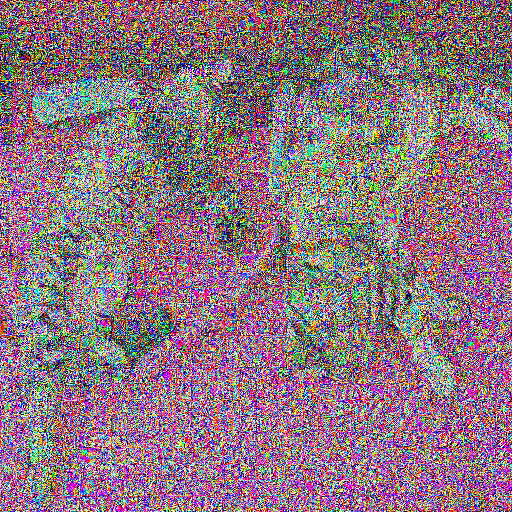

In [ ]:
display_tensor = denormalize(final_adv_image.squeeze(0)).clamp(0, 1).squeeze(0)
pil_image = to_pil_image(display_tensor)
display(pil_image)